## Use image labels to train CNN to classify images
### Classify as being orthoganal to street / looking at facade

In [3]:
import os
import sys
import re
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch


import torchvision
from torchvision import transforms

from torchvision import models
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# Set up dirs for jupyter notebook using cwd
dir_name = 'PGHComputerVision'
root = os.getcwd()
# sub out any text after dir_name to get project directory
root = re.sub(rf"{dir_name}.*", dir_name, root)

# create code and data directories
code_root = os.path.join(root, 'Code')
data_root = os.path.join(root, 'Data')

# Read in helper function
sys.path.append( os.path.join(code_root, 'helpers') )
from read_in_PGH_shp_files import load_pgh_shp_files


In [4]:
# read in facade labels dataset

facade_labels_path = os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown', 'facade_labels.csv')

assert os.path.exists(facade_labels_path), "facade_labels.csv not found"
labels_df = pd.read_csv(facade_labels_path)

labels_df['filename'] = labels_df['filename'].apply(lambda x: os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown', x))

# keep only non na labels
labels_df = labels_df.dropna(subset=['facade_label']).reset_index(drop=True)

# Remap labels .5 to 1 and 1 to 2
labels_df['facade_label'] = labels_df['facade_label'].apply(lambda x: 1 if x == .5 else (2 if x == 1 else x))   
labels_df['ortho_to_street'] = labels_df['ortho_to_street'].apply(lambda x: 1 if x == .5 else (2 if x == 1 else x))   
# convert to int
labels_df['facade_label'] = labels_df['facade_label'].astype(int)
labels_df['ortho_to_street'] = labels_df['ortho_to_street'].astype(int)

labels_df.head()


segment_id                                           filename  \
0  684842474-684842485  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
1  104572699-104573441  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
2  104572699-104573441  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
3  104572699-104573441  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
4  104572699-104573441  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   

   facade_label  ortho_to_street  
0             1                0  
1             2                2  
2             2                2  
3             2                2  
4             2                2

In [5]:
# Define a custom dataset
class OrdinalDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_col = 'facade_label'):
        self.dataframe = dataframe
        self.transform = transform
        self.label_col = label_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        label = self.dataframe.loc[idx, self.label_col]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # Convert label to cumulative probabilities
        #label_cum = [1] * (label + 1) + [0] * (2 - label)  # Adjust for the number of classes

        return image, torch.tensor(label, dtype=torch.float32)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # clip and rotate a little
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    # very minor color jitter
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])




# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)
# reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Create datasets and dataloaders for training and validation
train_dataset = OrdinalDataset(train_df, transform=transform)
val_dataset = OrdinalDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# print summ stats of train and val datasets
print(f'Training dataset: {len(train_dataset)} samples')
print(f'Validation dataset: {len(val_dataset)} samples')



Training dataset: 240 samples
Validation dataset: 60 samples


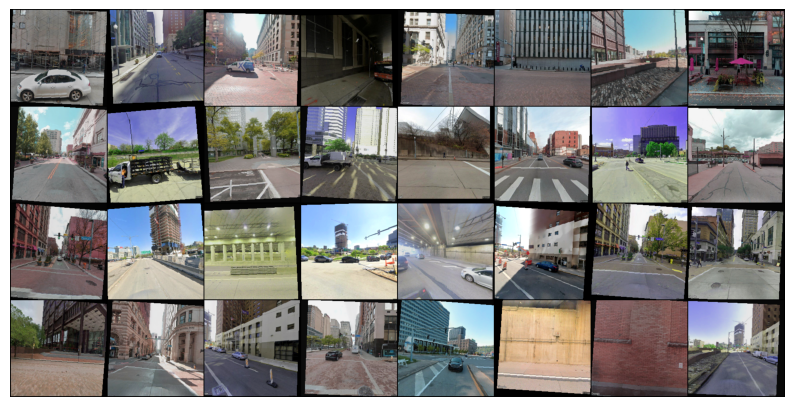

In [6]:
# Visualize the data
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get a batch of training data
inputs, targets = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the images
plt.figure(figsize=(10, 10))
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [7]:
# Load a pre-trained ResNet model
facade_model = models.resnet18(pretrained=True)

# Modify the last layer for regression
num_features = facade_model.fc.in_features
facade_model.fc = nn.Linear(num_features, 1)  # Output layer for regression

# Transfer model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
facade_model = facade_model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(facade_model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/SCHOOL/Year2_Spring/IndepStudyProject/PGHComputerVision/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/SCHOOL/Year2_Spring/IndepStudyProject/PGHComputerVision/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Training loop

# saves losses
train_losses = []
val_losses = []

epochs = 7
for epoch in range(epochs):
    facade_model.train()
    train_loss = 0.0
    # Train with tqdm progress bar
    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{epochs}'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = facade_model(images)
        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to match label dimensions
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    facade_model.eval()
    val_loss = 0.0
    # Validate with tqdm progress bar
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)
            outputs = facade_model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

    # Print results for the epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}\n')

    # save losses
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))



Training Epoch 1/7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Epoch 1/7: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch 1/7, Train Loss: 1.9117098227143288, Val Loss: 1.8712799549102783



Validation Epoch 2/7: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 2/7, Train Loss: 0.7674995213747025, Val Loss: 0.4752330332994461



Validation Epoch 3/7: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 3/7, Train Loss: 0.27636299282312393, Val Loss: 0.603176474571228



Validation Epoch 4/7: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 4/7, Train Loss: 0.1796450987458229, Val Loss: 0.9400007426738739



Validation Epoch 5/7: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 5/7, Train Loss: 0.18212226685136557, Val Loss: 0.5174449682235718



Validation Epoch 6/7: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Epoch 6/7, Train Loss: 0.13308847090229392, Val Loss: 0.2831927537918091



Validation Epoch 7/7: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

Epoch 7/7, Train Loss: 0.12071490474045277, Val Loss: 0.29579128324985504



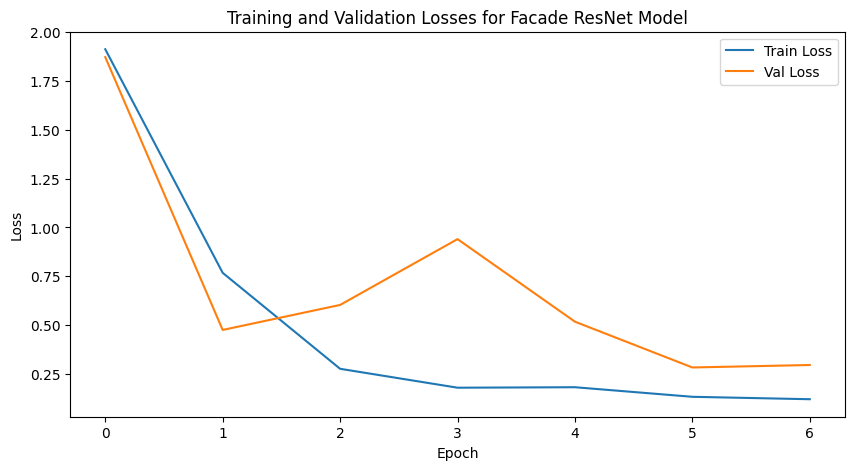

In [9]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses for Facade ResNet Model')
plt.show()


In [10]:
# save the model
model_dir = os.path.join(root, 'finetuned_models')
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'ResNet18_facade_detection.pth')
torch.save(facade_model.state_dict(), model_path)



In [11]:
# Create a test dataset
test_df = pd.read_csv(facade_labels_path)

# keep only na labels
test_df = test_df[test_df['facade_label'].isna()].reset_index(drop=True)

# append dir to filename
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown', x))

test_df.head()




segment_id                                           filename  \
0  684842467-684842468  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
1  684842468-736437289  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
2  684842467-736437289  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
3  684842467-736437264  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
4  684842467-736437264  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   

   facade_label  ortho_to_street  
0           NaN              NaN  
1           NaN              NaN  
2           NaN              NaN  
3           NaN              NaN  
4           NaN              NaN

In [12]:
# Create a test dataset
test_dataset = OrdinalDataset(test_df, transform=transform)

# Create a test dataloader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict the facade labels for the test dataset
facade_model.eval()
predictions = []
with torch.no_grad():
    for images, _ in tqdm(test_loader, desc='Predicting Facade Labels'):
        images = images.to(device)
        outputs = facade_model(images)
        predictions.extend(outputs.squeeze().cpu().numpy())

# Add the predictions to the test dataframe
test_df['facade_label'] = predictions

test_df.head()


Predicting Facade Labels: 100%|██████████| 106/106 [02:55<00:00,  1.65s/it]


segment_id                                           filename  \
0  684842467-684842468  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
1  684842468-736437289  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
2  684842467-736437289  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
3  684842467-736437264  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   
4  684842467-736437264  /Users/coltonlapp/Dropbox/My Mac (Coltons-MacB...   

   facade_label  ortho_to_street  
0     -0.078611              NaN  
1      0.069786              NaN  
2     -0.072640              NaN  
3     -0.085983              NaN  
4      0.212256              NaN

Text(0.5, 0.98, 'Images with Highest Predicted values of showing Facade')

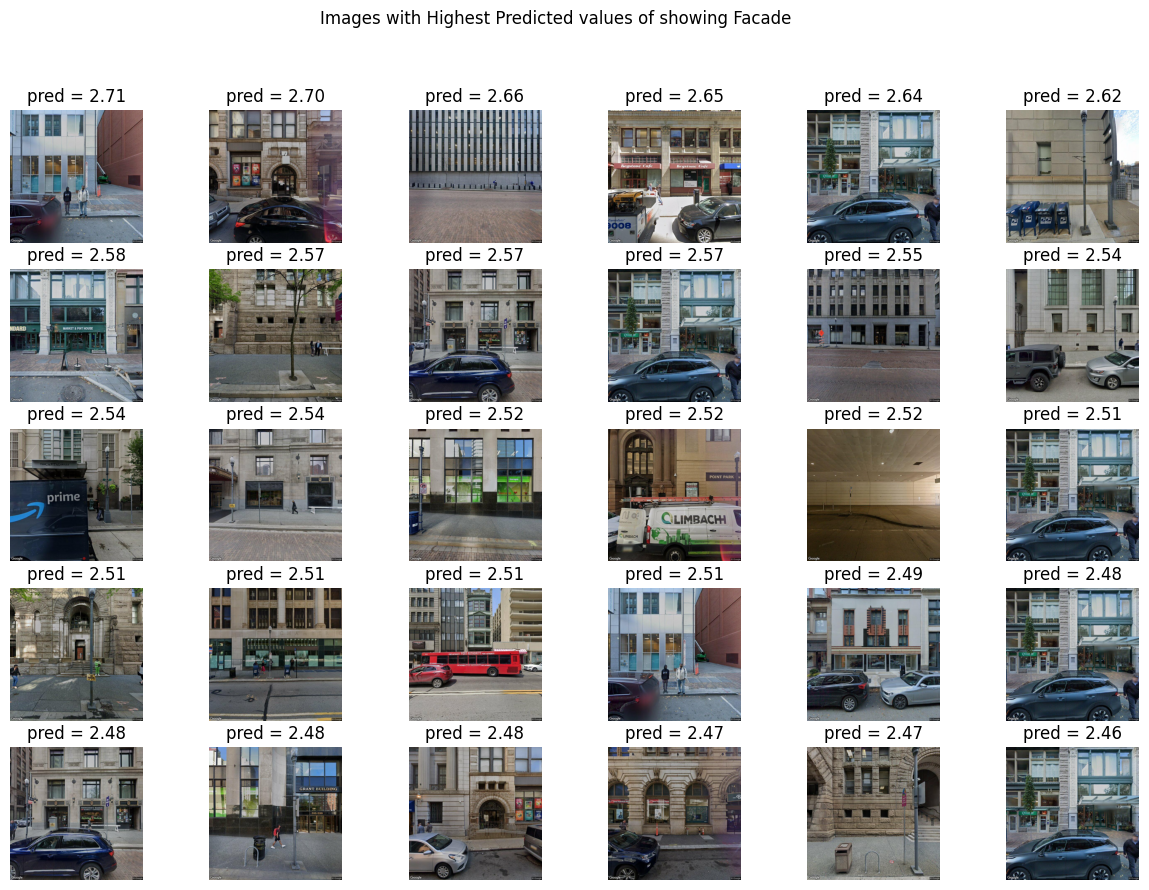

In [13]:
# Plot 30 small images subplot with highest values for facade_label
plt.figure(figsize=(15, 10))
for i in range(30):
    plt.subplot(5, 6, i + 1)
    img = Image.open(test_df.loc[test_df['facade_label'].idxmax(), 'filename'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'pred = {test_df.loc[test_df["facade_label"].idxmax(), "facade_label"]:.2f}')
    test_df.drop(test_df['facade_label'].idxmax(), inplace=True)

# overall title
plt.suptitle('Images with Highest Predicted values of showing Facade')


Text(0.5, 0.98, 'Images with Lowest Predicted values of showing Facade')

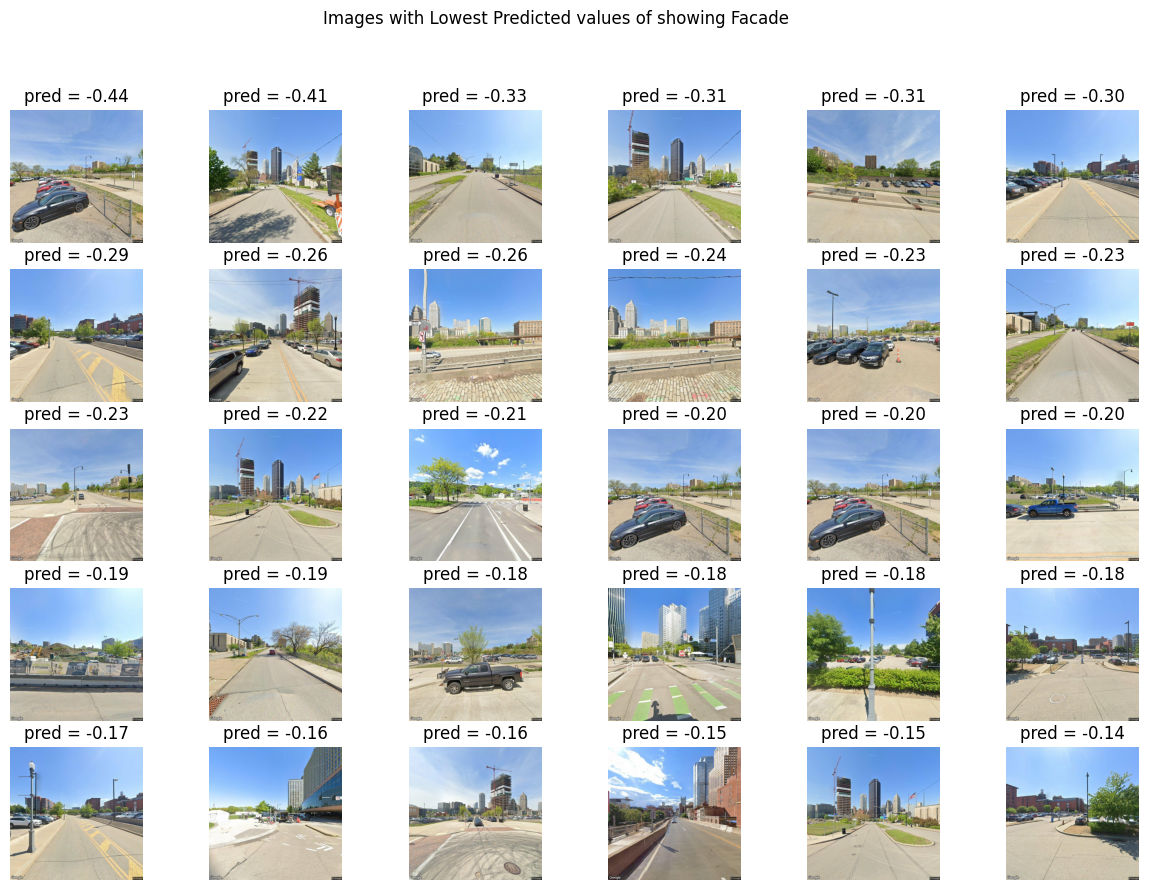

In [14]:
# plot 30 small images with lowest values for facade_label
plt.figure(figsize=(15, 10))
for i in range(30):
    plt.subplot(5, 6, i + 1)
    img = Image.open(test_df.loc[test_df['facade_label'].idxmin(), 'filename'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'pred = {test_df.loc[test_df["facade_label"].idxmin(), "facade_label"]:.2f}')
    test_df.drop(test_df['facade_label'].idxmin(), inplace=True)

# overall title
plt.suptitle('Images with Lowest Predicted values of showing Facade')

Text(0.5, 0.98, 'Images with Predicted values closest to 1')

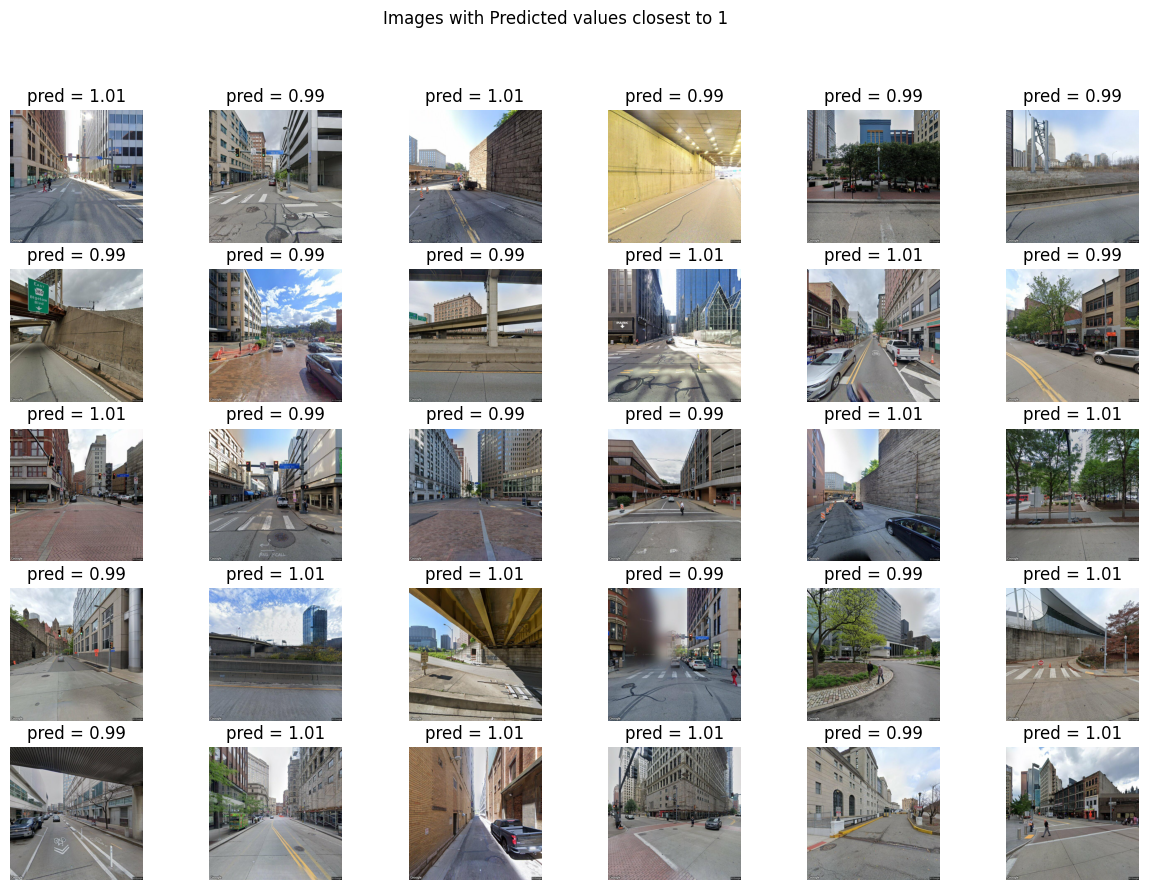

In [18]:
# Show 30 images with predicted values closest to 1
plt.figure(figsize=(15, 10))
test_df['dist_from_1'] = abs(test_df['facade_label'] - 1)
test_df = test_df.sort_values('dist_from_1')
for i in range(30):
    plt.subplot(5, 6, i + 1)
    img = Image.open(test_df.loc[test_df['dist_from_1'].idxmin(), 'filename'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'pred = {test_df.loc[test_df["dist_from_1"].idxmin(), "facade_label"]:.2f}')
    test_df.drop(test_df['dist_from_1'].idxmin(), inplace=True)

# overall title
plt.suptitle('Images with Predicted values closest to 1')


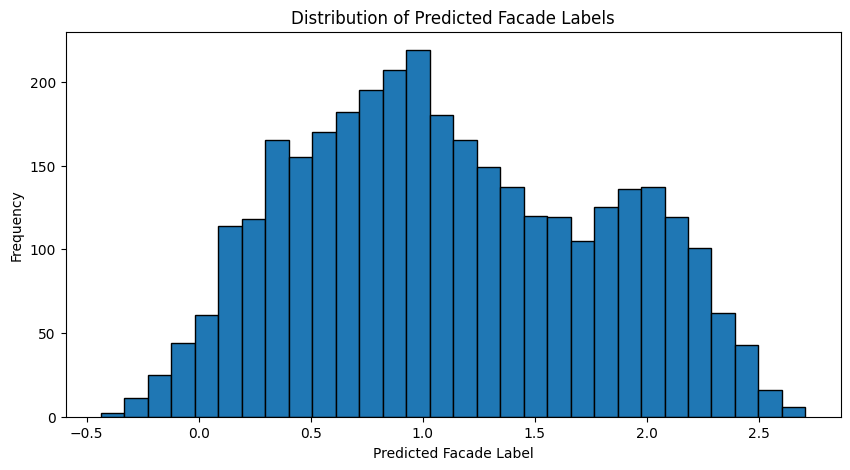

In [15]:
# plot distribution of predictions
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=30, edgecolor='black')
plt.xlabel('Predicted Facade Label')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Facade Labels')
plt.show()
